# Проект 
# Определение выгодного тарифа для телеком компании

<a id='step_0'></a><h3>Оглавление</h3>


[1. Описание проекта и данных](#step_1)  
[2. Загружаем файлы с данными и изучаем общую информацию](#step_2)   
[3. Предобработка](#step_3)      
    [3.1 Приводим все столбцы с датами к временному типу](#step_3.1)  
    [3.2 Округляем продолжительность звонков в верхнюю сторону и приводим к целому типу](#step_3.2)  
    [3.3 Удаляем лишние стобцы и добавляем нужные](#step_3.3)    
    [3.4 Подсчет количества услуг каждого пользователя в месяц](#step_3.4)  
[4. Анализ данных и подсчёт выручки](#step_4)   
    [4.1  Процент расторжения договоров](#step_4.1)  
    [4.2  Соединение всех таблиц в общую user_behavior с пользователями и полученными ими услугами от компании "Мега*"](#step_4.2)   
    [4.3  Пропуски в таблице user_behavior и их заполнени](#step_4.3)   
    [4.4  Присоединяем информацию о тарифах к таблице user_behavior](#step_4.4)  
    [4.5  Количество услуг пользователей сверх лимита по тарифу](#step_4.5)  
    [4.6 Расходы пользователей сверх лимита по тарифу](#step_4.6)  
    [4.7 Помесячная выручка каждого пользователя](#step_4.7)  
    [4.8 Сводная таблица месяц-тариф stats_df](#step_4.8)   
    [4.9 Распределение услуг по тарифам и по месяцам](#step_4.9)  
    [4.10 Распределение общей выручки по тарифам и по месяцам](#step_4.10)   
    [4.11 Количество услуг и выручка по тарифам за 2018 год](#step_4.11)   
[5. Проверка гипотез](#step_5)    
[5.1 Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается ](#step_5.1)   
[5.2 Проверка гипотезы: средняя выручка с пользователей из Москвы отличается от выручки c пользователей других регионов](#step_5.2)   
[6. Общий вывод](#step_6)    

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

<a id='step_1'></a><h3>1. Описание проекта и данных</h3>

[К оглавлению](#step_0)

**В аналитический отдел компании** «Мега*» — федерального оператора сотовой связи **поступила задача от коммерческого департамента**. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Нужно **оценить какой из тарифов приносит компании больше денег, чтобы скорректировать рекламный бюджет**.  
Предстоит сделать предварительный анализ тарифов **на выборке клиентов (500 пользователей «Мега*»)**: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018-й год. Задача проанализировать поведение клиентов и сделать вывод — какой тариф лучше для компании.  
Описание тарифов:  
**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  
Сообщение — 3 рубля.  
1 Гб интернет-трафика — 200 рублей.  
**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
Минута разговора — 1 рубль;  
Сообщение — 1 рубль;  
1 Гб интернет-трафика: 150 рублей.  

#### Описание данных  
**Таблица users** — информация о пользователях:  
**user_id** — уникальный идентификатор пользователя  
**first_name** — имя пользователя  
**last_name** — фамилия пользователя  
**age** — возраст пользователя (годы)  
**reg_date** — дата подключения тарифа (день, месяц, год)  
**churn_date** — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)  
**city** — город проживания пользователя  
**tarif** — название тарифного плана  
**Таблица calls** — информация о звонках:  
**id** — уникальный номер звонка  
**call_date** — дата звонка  
**duration** — длительность звонка в минутах  
**user_id** — идентификатор пользователя, сделавшего звонок  
**Таблица messages** — информация о сообщениях:  
**id** — уникальный номер звонка  
**message_date** — дата сообщения  
**user_id** — идентификатор пользователя, отправившего сообщение  
**Таблица internet** — информация об интернет-сессиях:  
**id** — уникальный номер сессии  
**mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)  
**session_date** — дата интернет-сессии  
**user_id** — идентификатор пользователя  
**Таблица tariffs** — информация о тарифах:  
**tariff_name** — название тарифа  
**rub_monthly_fee** — ежемесячная абонентская плата в рублях  
**minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату  
**messages_included** — количество сообщений в месяц, включённых в абонентскую плату  
**mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
**rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
**rub_per_message** — стоимость отправки сообщения сверх тарифного пакета  
**rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

<a id='step_2'></a><h3>2. Загружаем файлы с данными и изучаем общую информацию</h3>

[К оглавлению](#step_0)

In [2]:
# информация о звонках
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
# выводим на экран верх таблицы
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# смотрим информацию о таблице с звонками
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице  202607 строк и 4 столбца. Идентификатор звонка и дата звонка тип object, продолжительность - вещественное число и идентификатор пользователя -целое число.


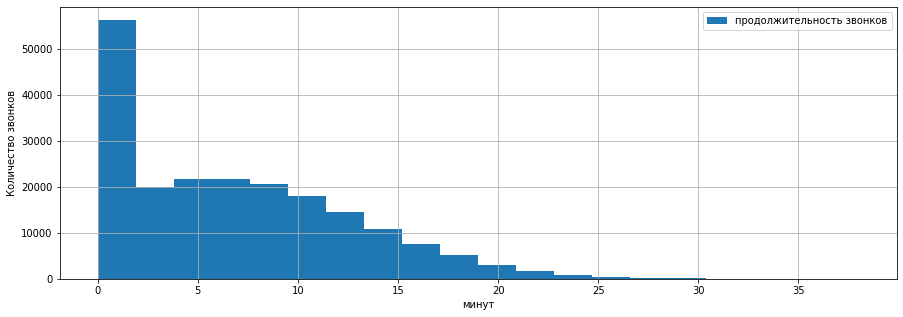

In [5]:
# выведем гистограмму для столбца с продолжительностью звонков
calls['duration'].hist(bins=20, figsize=(15, 5))
plt.legend(['продолжительность звонков'])
plt.xlabel('минут')
plt.ylabel('Количество звонков')
plt.show()

Данные имеют распределение Гаусса, скос вправо, на отметке 0 - выброс.

In [6]:
# таблица продолжительность сессий интернет траффика
sessions = pd.read_csv('/datasets/internet.csv')

In [7]:
# выводим на экран верх таблицы продолжительности сессий
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [8]:
# смотрим информацию о таблице с сессиями
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице sessions 149396 строк и 5 столбцов. Идентификатор и дата сессии - тип object, количество мегабайт - вещественное число, номер идентификатора пользователя - целое.

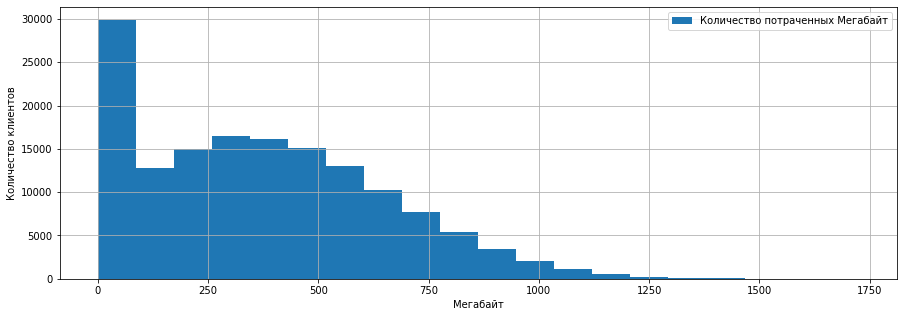

In [9]:
# выведем гистограмму для столбца с количеством потраченных мегабайт
sessions['mb_used'].hist(bins=20, figsize=(15, 5))
plt.legend(['Количество потраченных Мегабайт'])
plt.xlabel('Мегабайт')
plt.ylabel('Количество клиентов')
plt.show()

Данные имеют распределение Гаусса, скос вправо, на отметке 0 - выброс.

In [10]:
# таблица количество сообщений
messages = pd.read_csv('/datasets/messages.csv')

In [11]:
# выводим на экран верх таблицы количество сообщений
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
# смотрим информацию о таблице с сообщениями
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица messages имеет 123036 строк и 3 столбца. Идентификатор сообщения и дата сообщения - тип object, идентификатор пользоателя - целое число.

In [13]:
# датафрейм tariffs загружаем
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [14]:
# Выводим весь датафрейм tariffs
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [15]:
# информация о таблице tariffs
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице с тарифами 2 стороки и 8 столбцов. Наименование тарифа - строки, остальные столбцы - тип целое число.

In [16]:
# загружаем таблицу пользователей
users = pd.read_csv('/datasets/users.csv')

In [17]:
# Выводим верх таблицы
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [18]:
# информация о таблице пользователей
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице с пользователями 500 сторок и 8 столбцов. Наименование тарифа, город, фамили, имя и дата регистрации - строки, остальные столбцы (идентификатор пользователя и возраст) - тип целое число.

<a id='step_3'></a><h3>3. Предобработка</h3>

[К оглавлению](#step_0) 

<a id='step_3.1'></a><h3>3.1 Приводим все столбцы с датами к временному типу</h3>

[К оглавлению](#step_0) 

Приводим столбцы

- `reg_date` из таблицы `users`
- `churn_date` из таблицы `users`
- `call_date` из таблицы `calls`
- `message_date` из таблицы `messages`
- `session_date` из таблицы `sessions`

к временнОму типу с помощью метода `to_datetime()`.

In [19]:
# обработка столбца reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
# обработка столбца churn_date
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
# обработка столбца call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
# обработка столбца message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
# обработка столбца session_date
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format = '%Y-%m-%d')

<a id='step_3.2'></a><h3>3.2 Округляем продолжительность звонков в верхнюю сторону и приводим к целому типу</h3>

[К оглавлению](#step_0) 

В данных вы найдёте звонки с нулевой продолжительностью. Нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Однако в столбце `duration` датафрейма `calls` значения дробные. Округлим значения столбца `duration` вверх с помощью метода `numpy.ceil()` и приведем столбец `duration` к типу `int`.

In [20]:
calls['duration'] = np.ceil(calls['duration']).astype(int)

<a id='step_3.3'></a><h3>3.3 Удаляем лишние стобцы и добавляем нужные</h3>

[К оглавлению](#step_0) 

In [21]:
# Удалиv столбец Unnamed: 0 из датафрейма sessions
sessions = sessions.drop(columns='Unnamed: 0') 

In [22]:
# Создадим столбец month в датафрейме calls с номером месяца из столбца call_date
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [23]:
#  Создадим столбец month в датафрейме messages с номером месяца из столбца message_date
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [24]:
# Создадим столбец month в датафрейме sessions с номером месяца из столбца session_date
sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month

<a id='step_3.4'></a><h3>3.4 Подсчет количества услуг каждого пользователя в месяц</h3>

[К оглавлению](#step_0) 

In [25]:
# подсчёт количества звонков для каждого пользователя по месяцам
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))


In [26]:
# вывод 30 первых строк на экран
calls_per_month.head(30)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

In [27]:
# подсчёт израсходованных минут для каждого пользователя по месяцам
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))

In [28]:
# вывод первых 30 строк на экран
minutes_per_month.head(30)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212
        11         243
        12         236
1003    8          380
        9          961
        10         855
        11         824
        12         802
1004    5           35
        6          171
        7          135
        8          137
        9          117
        10         145
        11         117
        12         130

In [29]:
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))


In [30]:
# вывод первых 30 строк на экран
messages_per_month.head(30)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

In [31]:
# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})

In [32]:
# вывод первых 30 строк на экран
sessions_per_month.head(30)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

<a id='step_4'></a><h3>4. Анализ данных и подсчёт выручки</h3>

[К оглавлению](#step_0)  

<a id='step_4.1'></a><h3>4.1 Процент расторжения договоров</h3>

[К оглавлению](#step_0) 

In [33]:
# считаем процент расторгнутых договоров от общего числа
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор 7.6% клиентов из датасета

<a id='step_4.2'></a><h3>4.2 Соединение всех таблиц в общую user_behavior с пользователями и полученными ими услугами от компании "Мега*"</h3>

[К оглавлению](#step_0) 

Объединяем все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары «пользователь — месяц» будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [34]:
# создаем общий датафрейм
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\
# выводим верх таблицы
user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения:

<a id='step_4.3'></a><h3>4.3 Пропуски в таблице user_behavior и их заполнение</h3>

[К оглавлению](#step_0) 

In [35]:
# Проверим пропуски в таблице user_behavior после объединения:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Все столбцы с пропусками кроме churn_date заполним 0

In [36]:
# Заполним образовавшиеся пропуски в данных
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединяем информацию о тарифах

<a id='step_4.4'></a><h3>4.4 Присоединяем информацию о тарифах к таблице user_behavior</h3>

[К оглавлению](#step_0) 

In [37]:
# переименование столбца tariff_name на tariff
tariffs = tariffs.rename(
                         columns={
                                  'tariff_name': 'tariff'
                                  }
                        )

In [38]:
# Присоединяем информацию о тарифах
user_behavior = user_behavior.merge(tariffs, on='tariff')

<a id='step_4.5'></a><h3>4.5 Количество услуг пользователей сверх лимита по тарифу</h3>

[К оглавлению](#step_0) 

Считаем количество минут разговора, сообщений и мегабайт, превышающих включённые в тариф


In [39]:
# Считаем количество минут разговора превышающих включённые в тариф
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
# Считаем количество сообщений превышающих включённые в тариф
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
# Считаем количество  мегабайт, превышающих включённые в тариф
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']
# отрицательные значения заменяем на 0
for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`

In [40]:
# Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец paid_gb
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

<a id='step_4.6'></a><h3>4.6 Расходы пользователей сверх лимита по тарифу</h3>

[К оглавлению](#step_0) 

Считаем выручку за минуты разговора, сообщения и интернет

In [41]:
# Считаем выручку за минуты разговора
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
# Считаем выручку за сообщения
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
# Считаем выручку интернет
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

<a id='step_4.7'></a><h3>4.7 Помесячная выручка каждого пользователя</h3>

[К оглавлению](#step_0) 

Считаем помесячную выручку с каждого пользователя, она будет храниться в столбце `total_cost`

In [42]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

<a id='step_4.8'></a><h3>4.8 Сводная таблица месяц-тариф stats_df </h3>

[К оглавлению](#step_0) 

Датафрейм `stats_df` для каждой пары «месяц — тариф» будет хранить основные характеристики

In [43]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


<a id='step_4.9'></a><h3>4.9 Распределение услуг по тарифам и по месяцам </h3>

[К оглавлению](#step_0) 

Распределение среднего количества звонков по видам тарифов и месяцам

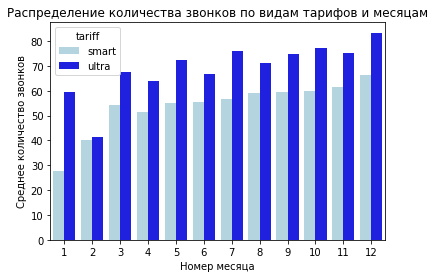

In [44]:
# Распределение среднего количества звонков по видам тарифов и месяцам
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

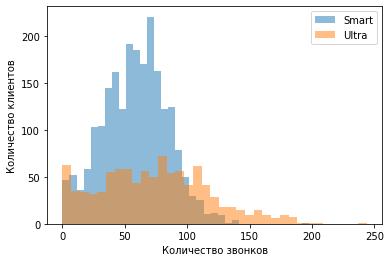

In [45]:
# Распределение среднего количества звонков по видам тарифов и месяцам
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Распределение средней продолжительности звонков по видам тарифов и месяцам

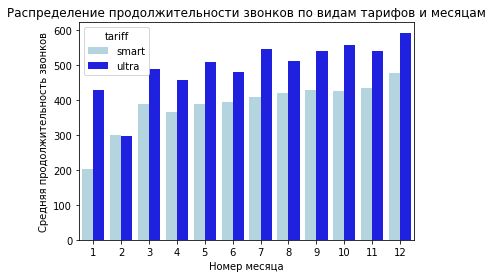

In [46]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

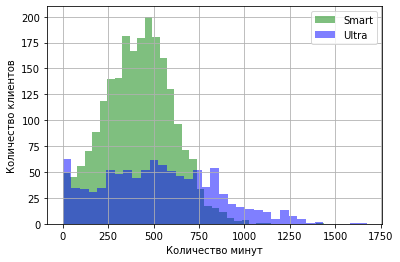

In [47]:
user_behavior[user_behavior['tariff'] =='smart']['minutes'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество минут')
plt.ylabel('Количество клиентов')
plt.show()

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

Распределение среднего количества сообщений по видам тарифов и месяцам

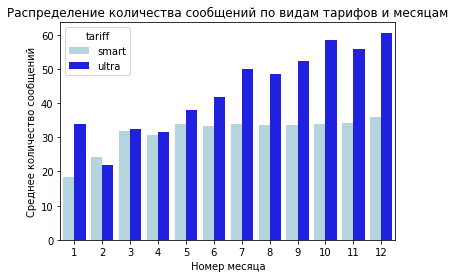

In [48]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

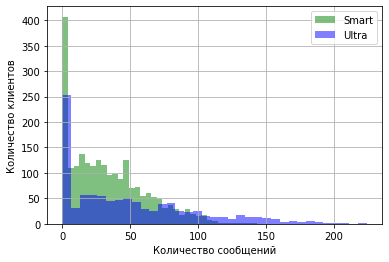

In [49]:
user_behavior[user_behavior['tariff'] =='smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['messages'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество сообщений')
plt.ylabel('Количество клиентов')
plt.show()

В среднем пользователи тарифа Ultra отправляют больше сообщений — почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифах растёт. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

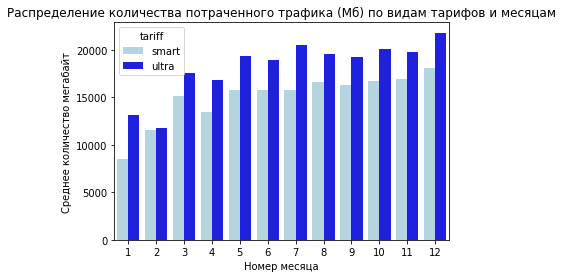

In [50]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue='tariff',
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравнение потраченных мегабайт среди пользователей тарифов Smart и Ultra

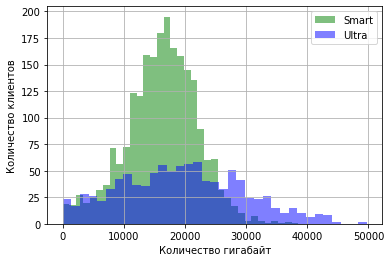

In [51]:
user_behavior[user_behavior['tariff'] =='smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество гигабайт')
plt.ylabel('Количество клиентов')
plt.show()

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15–17 Гб, а абоненты тарифного плана Ultra — 19–21 ГБ.

<a id='step_4.10'></a><h3>4.10 Распределение общей выручки по тарифам и по месяцам </h3>

[К оглавлению](#step_0) 

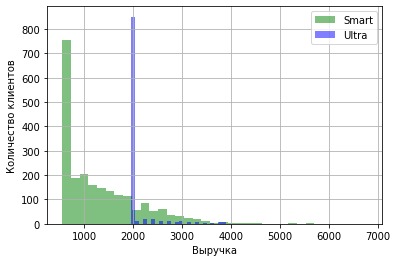

In [52]:
user_behavior[user_behavior['tariff'] =='smart']['total_cost'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['total_cost'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Выручка')
plt.ylabel('Количество клиентов')
plt.show()

<a id='step_4.11'></a><h3>4.11 Количество услуг и выручка по тарифам за 2018 год </h3>

[К оглавлению](#step_0) 

In [53]:
# Количество услуг по тарифам за 2018 год
user_behavior['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

In [54]:
# Выручка по тарифам за 2018 год
user_behavior[user_behavior['tariff'] =='smart']['total_cost']
total_df = user_behavior.pivot_table(
            index=['tariff'],\
            values=['total_cost'],\
            aggfunc=['sum']\
).reset_index()
total_df

,tariff,sum
,,total_cost
0,smart,2875351.0
1,ultra,2039100.0


#### Вывод:
Количество услуг и общая выручка тарифа Смарт больше

<a id='step_5'></a><h3>5. Проверка гипотез</h3>

[К оглавлению](#step_0)   

<a id='step_5.1'></a><h3>5.1 Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается </h3>

[К оглавлению](#step_0) 

Гипотезы:
```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"`
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"`
alpha = 0.05
```

In [55]:
# вызов метода для проверки гипотезы
results = st.ttest_ind (user_behavior[user_behavior['tariff'] =='smart']['total_cost'],
                        user_behavior[user_behavior['tariff'] =='ultra']['total_cost'], equal_var = False)
alpha = 0.05 #значение уровня значимости

print(results.pvalue) # вывод значения p-value на экран 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')# условный оператор с выводом строки с ответом
user_behavior['city'].unique()    

4.2606313931076085e-250
Отвергаем нулевую гипотезу


array(['Краснодар', 'Москва', 'Новокузнецк', 'Иваново', 'Омск', 'Уфа',
       'Томск', 'Санкт-Петербург', 'Тверь', 'Ярославль', 'Тюмень',
       'Ростов-на-Дону', 'Калуга', 'Тула', 'Волгоград', 'Саранск',
       'Иркутск', 'Череповец', 'Набережные Челны', 'Новосибирск',
       'Брянск', 'Тольятти', 'Нижний Тагил', 'Воронеж', 'Махачкала',
       'Пермь', 'Сургут', 'Пенза', 'Мурманск', 'Самара',
       'Нижний Новгород', 'Кемерово', 'Кострома', 'Оренбург', 'Чебоксары',
       'Магнитогорск', 'Астрахань', 'Нижневартовск', 'Челябинск',
       'Курган', 'Красноярск', 'Владивосток', 'Смоленск', 'Владимир',
       'Казань', 'Саратов', 'Севастополь', 'Рязань', 'Екатеринбург',
       'Стерлитамак', 'Ульяновск', 'Балашиха', 'Барнаул', 'Киров', 'Сочи',
       'Вологда', 'Чита', 'Петрозаводск', 'Хабаровск', 'Ставрополь',
       'Улан-Удэ', 'Курск', 'Якутск', 'Химки', 'Владикавказ', 'Ижевск',
       'Орёл', 'Белгород', 'Архангельск', 'Липецк', 'Волжский', 'Тамбов',
       'Калининград', 'Новороссий

Вывод: Суммарная выручка двух тарифов не равна

<a id='step_5.2'></a><h3>5.2 Проверка гипотезы: средняя выручка с пользователей из Москвы отличается от выручки c пользователей других регионов </h3>

[К оглавлению](#step_0) 

 Гипотезы:  

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы`
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы`
alpha = 0.05
```

In [56]:
# вызов метода для проверки гипотезы
results = st.ttest_ind (user_behavior[user_behavior['city'] =='Москва']['total_cost'],
                        user_behavior[user_behavior['city'] !='Москва']['total_cost'], equal_var = False)
alpha = 0.05 # значение уровня значимости

print(results.pvalue) # вывод значения p-value на экран 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')# условный оператор с выводом строки с ответом


0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Вывод: Гипотезу о равенстве общей выручки пользователей из Москвы и пользователей из регионов не получилось отвергнуть

<a id='step_6'></a><h3>6. Общий вывод</h3>

[К оглавлению](#step_0)   

В тарифе Ультра пользователи больше говорят, тратят интернет и отправляют сообщения, однако, несмотря на это выручка тарифа Смарт больше. Общая выручка тарифов от пользователей Москвы сопоставима с общей выручкой всех пользователей из других регионов.
Поэтому рекламному отделу компании "Мега*" **рекомендовано больше тратить рекламный бюджет на тариф Смарт в регионе Москва**.